# AOS AuxTel test data : run on multiple exposures

Setup:

    ssh -L 54467:localhost:54467 scichris@lsst-devl02
    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib
    source /project/scichris/aos/setup_aos_current.sh
    jupyter notebook --no-browser --port=54467

Use data from https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py#L222
https://github.com/lsst-ts/ts_externalscripts/blob/develop/tests/auxtel/test_latiss_cwfs_align.py#L412 , used in unit tests: 
    
    2021032300308
    2021032300310
    


In [1]:
from lsst.daf import butler as dafButler
butler = dafButler.Butler('/repo/main/')

registry = butler.registry
datasetRefs = list(registry.queryDatasets(instrument='LATISS', datasetType='raw', collections=['LATISS/raw/all'],
                                          where="exposure.day_obs=20210323"
                                         ))
datasetRefs[0]

DatasetRef(DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure), {instrument: 'LATISS', detector: 0, exposure: 2021032300001, ...}, id=c17708d6-c627-5431-a836-28cd2cfff8ef, run='LATISS/raw/all')

In [5]:
%matplotlib inline
from astropy.io import fits
from astropy.visualization import ZScaleInterval
import matplotlib.pyplot as plt
import numpy as np 
zscale = ZScaleInterval()


def preview_auxtel_exposures(year='2021', monthDay='0908', expStart=483, expEnd=490,
                            datasetRefOrType='raw', collection='LATISS/raw/all'):

    butler = dafButler.Butler('/repo/main/')
    
    # figure out how many images to plot
    nexp = expEnd-expStart

    # calculate how many cols and rows we need 
    if nexp > 3:
        ncol = 3
        nrows = (nexp // ncol) + 1
    else:
        ncol=nexp
        nrows = 1
        
    # do the plotting 
    fig,axs = plt.subplots(nrows,ncol,figsize=(ncol*4,nrows*4))
    ax = np.ravel(axs)
    i=0
    for exp in range(expStart,expEnd):
        exposure = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                         'exposure':int(f'{year}{monthDay}00{exp}')
                                            },
                          collections=[collection])
        data = exposure.image.array
        vmin, vmax = zscale.get_limits(data)
        ax[i].imshow(data,vmin=vmin,vmax=vmax,origin=
                  'lower')
        ax[i].set_title(f"{year}{monthDay}, exp {exp},\n focusz={np.round(exposure.getMetadata()['FOCUSZ'],3)}")
        i += 1
    fig.subplots_adjust(hspace=0.25)

    # if there are more axes than exposures,
    # turn off the extra axes 
    ncells = nrows*ncol
    if ncells > nexp:
        for axis in ax[nexp:]:
            axis.axis("off")

/lsstdata/offline/instrument/LATISS/storage/2021-03-23/AT_O_20210323_000307-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-03-23/AT_O_20210323_000308-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-03-23/AT_O_20210323_000309-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-03-23/AT_O_20210323_000310-R00S00.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/lsstdata/offline/instrument/LATISS/storage/2021-03-23/AT_O_20210323_000311-R00S00.fits: outAmp.getRawBBox() != data.getBBox

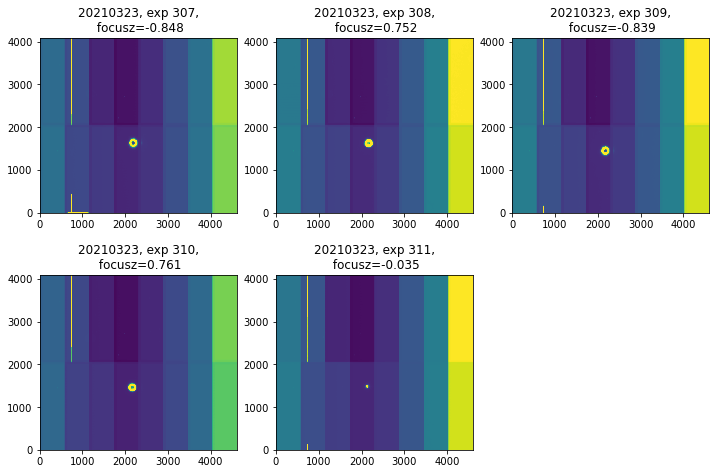

In [3]:
from lsst.daf import butler as dafButler
preview_auxtel_exposures(year='2021',monthDay='0323', expStart=307, expEnd=312)

Run the ISR: 

    ssh lsst-devl02

    source "/software/lsstsw/stack/loadLSST.bash"
    setup lsst_distrib

    pipetask run  --data-query "exposure IN (2021032300307,2021032300308,2021032300309,2021032300310,2021032300311,2021032300312) AND instrument='LATISS' " -b /repo/main/butler.yaml --input  LATISS/raw/all,LATISS/calib,u/czw/DM-28920/calib.20210720  --output u/scichris/Latiss/postISRtest2 --pipeline /project/scichris/aos/testLatiss4.yaml  --register-dataset-types
    
    
  

Show the postISR:

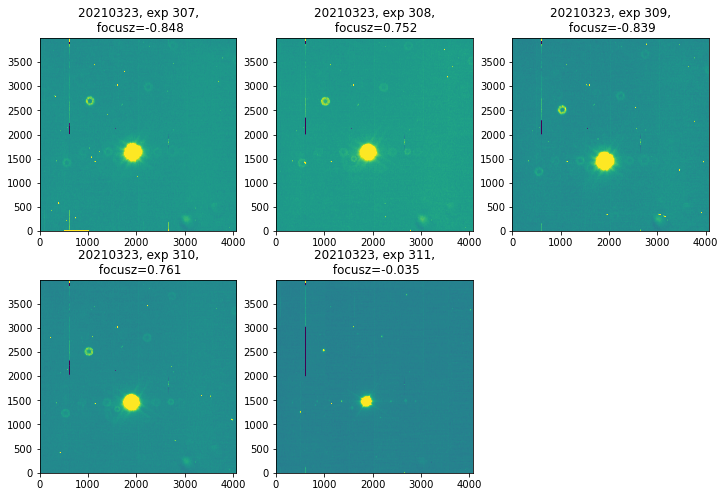

In [6]:
preview_auxtel_exposures(datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRtest',
                        year='2021', monthDay='0323', expStart=307, expEnd=312)

Run the donut detection via template fitting, and Zernike estimation. Store the results:

In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from copy import copy
from lsst.ts.wep.DonutDetector import DonutDetector
from lsst.daf import butler as dafButler

def fit_zernikes(estimateZernikeTask, exp=307,year='2021', monthDay='0323',
                datasetRefOrType='postISRCCD', collection='u/scichris/Latiss/postISRtest',):

    butler = dafButler.Butler('/repo/main/')
    
    # load the exposure pair 
    exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp}')
                                                }, collections=[collection])

    exposure_extra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp+1}')
                                                }, collections=[collection])

    # declare the exposure pair
    exposure_pair = [exposure_intra, exposure_extra ]

    print(f'\nRunning Zk fitting for exposure={exp}')


    # get the  template from estimateZernikeTask. 

    detectorName = exposure_extra.getDetector().getName()
    pixelScale = exposure_extra.getWcs().getPixelScale().asArcseconds()
    defocalType = DefocalType.Extra
    template = estimateZernikeTask.getTemplate(detectorName, defocalType, pixelScale)

    # detect donuts  in one of the defocal images 
    detector = DonutDetector()
    expArray = copy(exposure_extra.getImage().getArray())

    # use the adaptive threshold finding algorithm for the binary image 
    donutDf = detector.detectDonuts(expArray, template, blendRadius=200,
                                       peakThreshold=0.99, binaryChoice = 'deblend')
    np.save(f'donuts_{year}{monthDay}00{exp}.npy', donutDf)

    # make a donut catalog :
    ## remove the blends in donut catalog 
    donutDfClean = donutDf[~donutDf['blended']].copy()

    ## update column names and content 
    donutCatUpd = update_donut_cat(donutDfClean.copy(), exposure_intra)

    # run zernike estimation
    zernikeOutput = estimateZernikeTask.run(exposure_pair, donutCatUpd, "LATISS")

    # store zernikes as dict
    zernikes = zernikeOutput.getDict()
    fname = f'zerDic_{year}{monthDay}00{exp}.npy'
    np.save(fname,zernikes)
    print(f'Stored the results as {fname} ')
    
def update_donut_cat(donutCat, exposure):
    
    ## rename columns, as the EstimateZernikes  expects different names:
    ## coord_ra; coord_dec; centroid_x; centroid_y; source_flux; detector; mags
    
    
    # and add a detector column 
    donutCat['detector'] = exposure.getDetector().getName()

    # rename columns: transpose y --> x 
    donutCat = donutCat.rename(columns={"y_center":"centroid_x", "x_center":"centroid_y"})
    
    # pass whatever ra,dec to the catalog - they're not used, but are required to be there 
    wcs = exposure.getWcs()
    x = np.array(donutCat['centroid_x'].values)
    y = np.array(donutCat['centroid_y'].values)

    x = np.zeros(0)
    for row in donutCat['centroid_x'] : 
        x = np.append(x, row)

    ra,dec = wcs.pixelToSkyArray(x,y,degrees=False)  
    
    donutCat['coord_ra'] = ra
    donutCat['coord_dec'] = dec
    return donutCat

In [8]:
# initialize the zernike Task - has to be done only once 
from lsst.ts.wep.task.EstimateZernikesLatissTask import EstimateZernikesLatissTask, EstimateZernikesLatissTaskConfig
estimateZernikeConfig = EstimateZernikesLatissTaskConfig(donutStampSize=200,donutTemplateSize=200)
estimateZernikeTask = EstimateZernikesLatissTask(config=estimateZernikeConfig)
estimateZernikeTask.instName = 'auxTel'
estimateZernikeTask.opticalModel = 'onAxis'

for exp in [307,309]:
    fit_zernikes(estimateZernikeTask, exp=exp)


Running Zk fitting for exposure=307
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
Using deblendAdapt _getImgBinaryAdapt to get image binary
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
In DonutTemplateModel using opticalModel onAxis
and maskScalingFactorLocal=2.0
0 / 1
imageCoCenter: (x, y) = (   99.81,   98.01)

imageCoCenter: (x, y) = (  103.12,   92.96)

itr = 0, z4-z22
[ -25.   -9.   70. -141.   28.   -6.   11.   -9.   -1.    2.   27.   -5.
   -6.   22.    1.    2.    6.   12.    9.]
itr = 1, z4-z22
[ -38.   -5.   78. -146.   33.   -6.    9.   -8.   -2.    1.   27.   -7.
   -8.   25.    2.    2.    6.   11.    9.]
itr = 2, z4-z22
[ -51.    4.   91. -158.   39.   -5.    6.   -7.   -3.   -1.   27.   -8.
  -11.   32.    3.    2.    6.   11.    9.]
itr = 3, z4-z22
[ -63.    5.  134. -171.   37.   -8.    6.   -7.   -4.   -2.   27.   -7.
  -10.   38.    3.    2.    7.   11.    9.]
itr = 4, z4-z22
[ -72.   16.  168. -182.

Illustrate the results:

Text(0.5, 1.0, 'exp309')

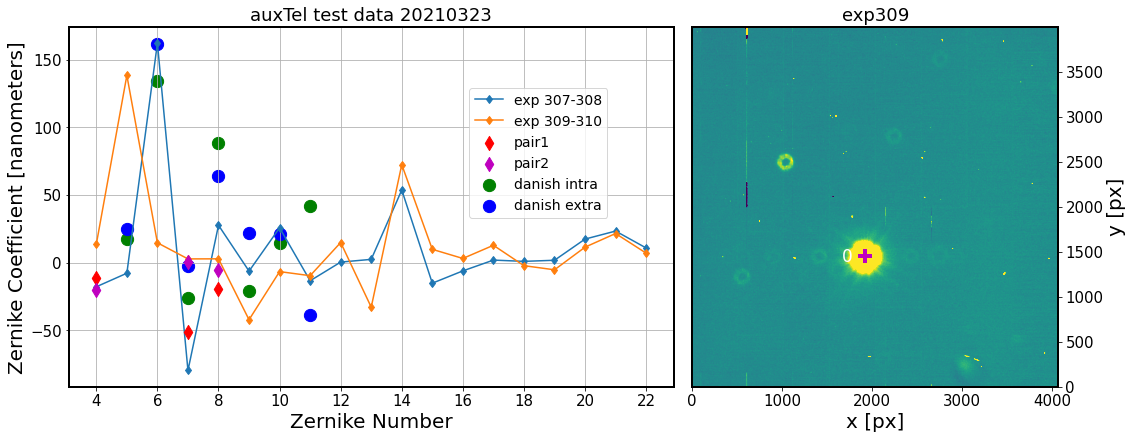

In [38]:
# plot the truth vs simulation... 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from lsst.ts.wep.Utility import DefocalType
from copy import copy
from lsst.ts.wep.DonutDetector import DonutDetector
import yaml
from astropy.io import fits  
from astropy.visualization import ZScaleInterval

from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18



exp=309
year='2021'
monthDay='0323'


donutCat = np.load(f'donuts_{year}{monthDay}00{exp}.npy',allow_pickle=True)

# plot the figure ...   
fig = plt.figure(figsize=(14, 5))

####################################
### left - plot the fit results  ###
#################################### 

#add_axes([xmin,ymin,dx,dy]) 
ax1 = fig.add_axes([0,0,0.6,1])  

for exp in [307,309]:
    zkResultsFile = f'zerDic_{year}{monthDay}00{exp}.npy'
    zkFit = np.load(zkResultsFile, allow_pickle=True).item()

    for i in range(len(zkFit['outputZernikesRaw'])):
        ax1.plot(np.arange(4, 23),1000*zkFit['outputZernikesRaw'][i], 
                 '-d', label=f'exp {exp}-{exp+1}')

ax1.scatter([8,7,4], [-19.40256, -51.19022, -11.11000], 
            c='r', marker='d',s=100,zorder=10,label='pair1')

ax1.scatter([8,7,4], [-5.156342491620025, 0.6554215087770965, -19.8341551660864],
            c='m', marker='d',s=100,zorder=10,label='pair2')

danish_4_11_intra_nm = [-3104.618,17.177,134.087,-26.133,88.511,-20.925,14.620 ,41.928]
danish_4_11_extra_nm = [2951.144,24.803,161.688 ,-2.071,64.181,21.840,21.485,-38.272]

ax1.scatter(np.arange(5,12), danish_4_11_intra_nm[1:], s=150, c='green', label='danish intra')
ax1.scatter(np.arange(5,12), danish_4_11_extra_nm[1:], s=150, c='blue',label='danish extra')

ax1.set_xlabel('Zernike Number',)
ax1.set_ylabel('Zernike Coefficient [nanometers]', )
ax1.legend(fontsize=14, loc='center left', bbox_to_anchor=[.65, 0.65])
ax1.set_xticks(np.arange(4,23)[::2])
ax1.grid()


ax1.set_title(f'auxTel test data {year}{monthDay}', fontsize=18)


###############################################
### right - plot the postISR image ###
###############################################


ax2 = fig.add_axes([0.6,0,0.4,1])
butler = dafButler.Butler('/repo/main/')
datasetRefOrType='postISRCCD'; collection='u/scichris/Latiss/postISRtest'
exposure_intra = butler.get(datasetRefOrType, dataId={'instrument':'LATISS', 'detector':0, 
                                             'exposure':int(f'{year}{monthDay}00{exp}')
                                                }, collections=[collection])
zscale = ZScaleInterval()
data = exposure_intra.image.array
vmin, vmax = zscale.get_limits(data)

ax2.imshow(data, origin='lower', vmin=vmin, vmax=vmax)

nrows = len(zkFit['donutStampsExtra'])
for i in range(nrows):
    donut = zkFit['donutStampsExtra'][i]
    xy = donut.centroid_position

    # plot the cross marking that the donut was used 
    ax2.scatter(xy[0],xy[1],s=200,marker='+',c='m', lw=4)

    # plot the donut number on the plot 
    xtext,ytext = xy[0],xy[1]
    ytext -= 60
    if xtext+100 > 4096:
        xtext -= 250
    if len(str(i))>1: # move to the left label thats too long 
        #print(i, 'moving')
        xtext -=340 
    else:
        xtext -=260
    ax2.text(xtext, ytext, f'{i}', fontsize=17, c='white' )    
ax2.yaxis.tick_right()
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')
ax2.yaxis.set_label_position("right")
ax2.set_title(f'exp{exp}')